# 在Dynex神经形态平台上的计算：图像分类

在量子或神经形态系统上的计算与使用传统硬件基本不同，是一个非常活跃的研究领域，几乎每周都会涌现出新的算法。在本文中，我们将使用Dynex SDK（beta版）来执行一个基于迁移学习方法的图像分类任务，该方法基于一篇题为《一种用于受限Boltzmann机推理的混合量子-经典方法》的论文中提到的Quantum-Restricted-Boltzmann-Machine（"QRBM"）。这是一个逐步指南，介绍如何使用PyTorch在Python中利用神经形态计算。这个示例只是执行机器学习任务的多种可能性之一。然而，它可以很容易地适用于其他用例。

In [42]:
import math
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.linear_model import LogisticRegression

## 导入Dynex Pytorch层的类

Dynex平台可以作为一个神经形态PyTorch层来使用。我们导入所需的类：

In [43]:
from HybridQRBM.pytorchdnx import dnx
from HybridQRBM.optimizers import RBMOptimizer
from HybridQRBM.samplers import DynexSampler

## 参数

我们定义训练的超参数。神经形态的Dynex层在非常快的时间内趋向于接近最优的基态。因此，我们只需要少数的训练周期来训练一个完全训练好的模型。

In [44]:
INIT_LR    = 1e-3  # 优化器的初始损失率
BATCH_SIZE = 10000 # 每批次图像数量
EPOCHS     = 1     # 训练时期数
device = "cpu"     # 不需要 GPU，我们在 Dynex 平台上计算

## 定义 PyTorch 模型

In [45]:
optimizer = RBMOptimizer(
                learning_rate=0.05,
                momentum=0.9,
                decay_factor=1.00005,
                regularizers=()
            );
sampler = DynexSampler(mainnet=True,num_reads=100000,annealing_time=200,debugging=False,logging=True,num_gibbs_updates=1,minimum_stepsize=0.002)
"""sampler = DynexSampler(mainnet=True, 
                       num_reads=100000,
                       annealing_time=200,
                       debugging=False,
                       logging=True,
                       num_gibbs_updates=1,
                       description='Image_Classification_By_Rumony',
                       minimum_stepsize=0.002);"""



"sampler = DynexSampler(mainnet=True, \n                       num_reads=100000,\n                       annealing_time=200,\n                       debugging=False,\n                       logging=True,\n                       num_gibbs_updates=1,\n                       description='Image_Classification_By_Rumony',\n                       minimum_stepsize=0.002);"

我们定义一个只有一个Dynex神经形态层的模型。这个层被设计为在整个图像批次上找到能量基态 - 所有这些都在Dynex平台上完全并行计算。从技术上讲，它是一个QRBM（量子受限玻尔兹曼机）层，返回隐藏节点权重。为了进行分类，我们将基于这个层的隐藏层应用一个简单的逻辑回归模型。

In [46]:
class QModel(nn.Module):
    def __init__(self, n_hidden, steps_per_epoch, sampler, optimizer):
        super().__init__();
        # Dynex 神经形态层
        self.dnxlayer = dnx(n_hidden, steps_per_epoch, sampler=sampler, optimizer=optimizer); 
        
    def forward(self, x):
        x = self.dnxlayer(x);
        return x

## 加载MNIST数据集

PyTorch默认带有MNIST参考数据集。

In [47]:

class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  

data_transformer = transforms.Compose([
        transforms.ToTensor(),
        ThresholdTransform(thr_255=128) 
    ])

In [48]:
from torchvision.datasets import MNIST
trainData = MNIST(root="data", train=True, download=True, transform=data_transformer)
testData = MNIST(root="data", train=False, download=True, transform=data_transformer) 
print("[INFO] MNIST dataset lodaed")

[INFO] MNIST dataset lodaed


In [49]:
# 初始化训练、验证和测试数据加载器
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

## 模型训练

模型累积所有的60,000张训练图像，并在整个周期内并行处理采样：

In [50]:
steps_per_epoch = len(trainDataLoader.dataset) // BATCH_SIZE
# 定义一个具有300个隐藏节点的模型：
model = QModel(300, steps_per_epoch, sampler, optimizer); 

In [51]:
for e in range(1, EPOCHS+1):
    print('EPOCH',e,'of',EPOCHS);
    # 将模型设置为训练模式
    model.train()
    # 循环遍历训练集
    for (x, y) in trainDataLoader:
        # 将输入发送到设备
        (x, y) = (x.to(device), y.to(device))
        # 执行前向传递并计算训练损失
        pred = model(x);
    
print('FOUND MODEL ACCURACY:',np.array(model.dnxlayer.acc).max(),'%')

╭────────────┬───────────┬────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS READ │   CHIPS │   STEPS │   GROUND STATE │
├────────────┼───────────┼────────────────┼─────────┼─────────┼────────────────┤
│       7775 │    172.73 │             43 │  173376 │     200 │   875566994.00 │
╰────────────┴───────────┴────────────────┴─────────┴─────────┴────────────────╯
╭───────────┬───────────────┬─────────┬────────┬──────────────┬───────────┬───────────────┬──────────╮
│    WORKER │       VERSION │   CHIPS │    LOC │       ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────┼───────────────┼─────────┼────────┼──────────────┼───────────┼───────────────┼──────────┤
│ 165641307 │ 2.3.0.OZM.125 │    4896 │ 112686 │ 875566994.00 │  1.13 min │   531.00s ago │  STOPPED │
├───────────┼───────────────┼─────────┼────────┼──────────────┼───────────┼───────────────┼──────────┤
│ 165648941 │ 2.3.0.OZM.125 │    1504 │ 113038 │ 880587590.00 │  1.05 min │   16

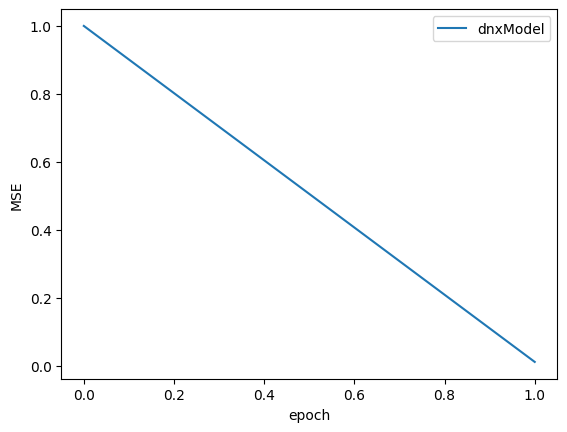

[1.0, 0.011050180835348622]


In [52]:
# 可视化进度：
plt.figure()
plt.plot(model.dnxlayer.errors, label='dnxModel')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()
print(model.dnxlayer.errors)

## 可视化测试数据集：

1  batches total 10000 images in total, one batch 10000 images


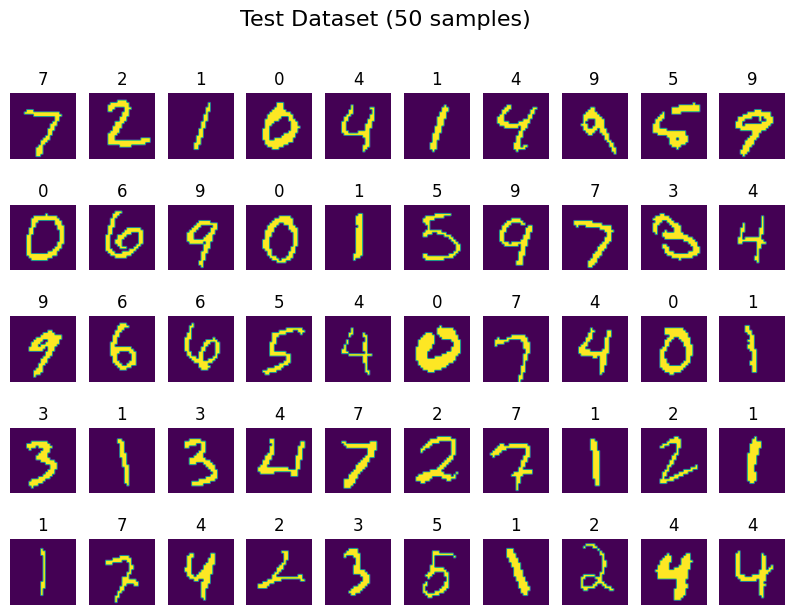

In [53]:
num_samp = 0;
num_batches = 0;
for batch_idx, (inputs, targets) in enumerate(testDataLoader):
    num_samp += len(inputs);
    num_batches += 1;
    
print(num_batches,' batches total', num_samp,'images in total, one batch',len(inputs),'images')

# 我们使用来自最后一个批次的数据：
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Test Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;

for j in range(0,50):
    fig.add_subplot(rows, columns, j+1)
    plt.imshow(inputs[j][0])
    marker=str(targets[j].tolist())
    plt.title(marker)
    plt.axis('off');
    
plt.show();

## 迁移学习：从RBM的隐藏层进行逻辑回归分类器

In [54]:
data = [];
data_labels = [];
error = 0;
for i in range(0, 150):
    inp = np.array(inputs[i].flatten().tolist()); 
    tar = np.array(targets[i].tolist())
    data.append(inp)
    data_labels.append(tar)
data = np.array(data)
data_labels = np.array(data_labels)

In [55]:
# 从RBM中提取隐藏层：
hidden, prob_hidden = model.dnxlayer.sampler.infer(data)

In [56]:
# 在隐藏节点上进行逻辑回归分类：
t = hidden * prob_hidden
clf = LogisticRegression(max_iter=10000)
clf.fit(t, data_labels)
predictions = clf.predict(t)
print('Accuracy:', (sum(predictions == data_labels) / data_labels.shape[0]) * 100,'%')

Accuracy: 87.33333333333333 %


In [57]:
# 检查预测结果：
print('target   :',data_labels[:30])
print('predicted:',predictions[:30])

target   : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predicted: [7 2 1 0 4 1 4 4 0 9 0 2 9 0 1 5 4 7 3 4 9 6 6 5 4 0 7 4 0 1]


## 使用RBM进行图像重建：

In [58]:
_, features = model.dnxlayer.sampler.predict(data, num_particles=10,num_gibbs_updates=1)

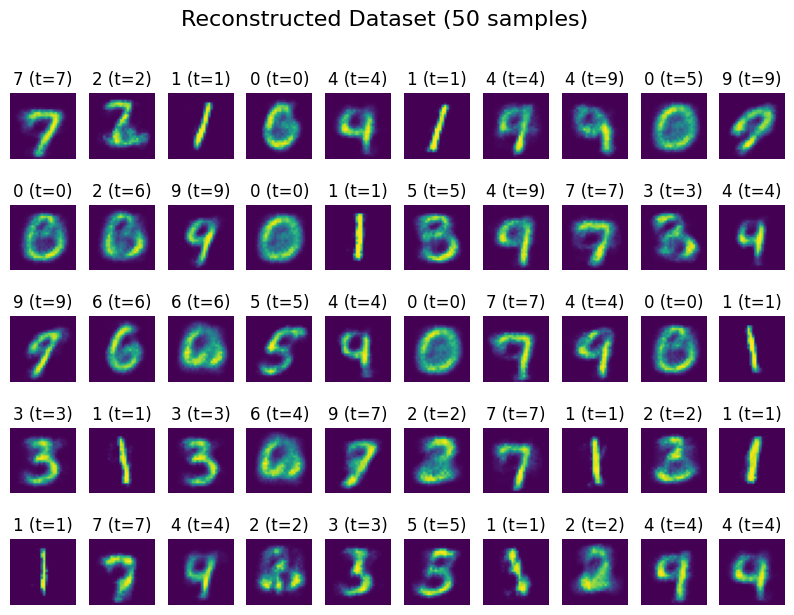

In [59]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;
for i in range(0,50):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features[i].reshape(28,28))
    marker=str(predictions[i])+' (t='+str(data_labels[i])+')'
    plt.title(marker)
    plt.axis('off');
plt.show()

## 保存模型

In [60]:
torch.save(model, './checkpoint/ckpt.pth')

## 加载模型并进行预测

In [61]:
testmodel = torch.load('./checkpoint/ckpt.pth');

In [62]:
# 验证模型是否被正确加载：
testmodel.dnxlayer.weights == model.dnxlayer.weights

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [63]:
_, features = testmodel.dnxlayer.sampler.predict(data, num_particles=10,num_gibbs_updates=1)

In [64]:
# 从RBM中提取隐藏层：
hidden, prob_hidden = testmodel.dnxlayer.sampler.infer(data)
# 在隐藏节点上进行逻辑回归分类：
from sklearn.linear_model import LogisticRegression
t = hidden * prob_hidden
clf = LogisticRegression(max_iter=10000)
clf.fit(t, data_labels)
predictions = clf.predict(t)
print('Accuracy:', (sum(predictions == data_labels) / data_labels.shape[0]) * 100,'%')

Accuracy: 89.33333333333333 %


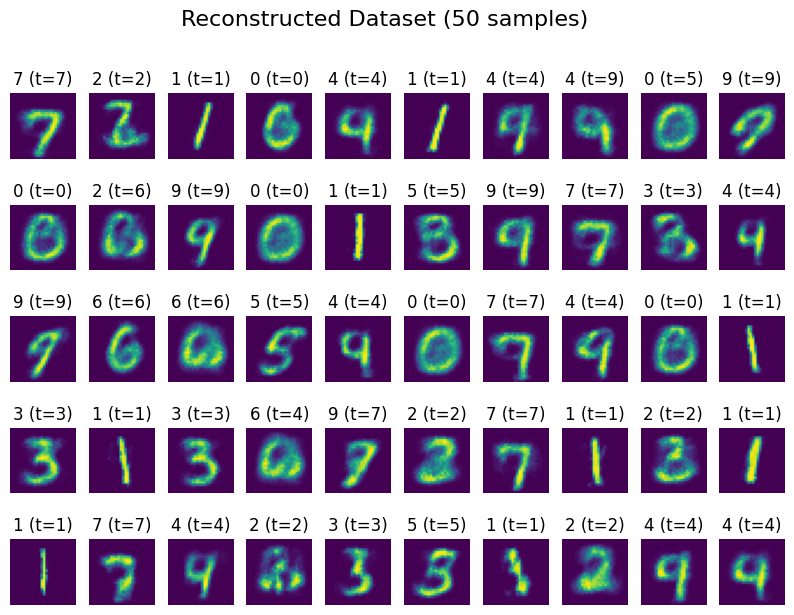

In [65]:
fig = plt.figure(figsize=(10, 7));
fig.suptitle('Reconstructed Dataset (50 samples)', fontsize=16)
rows = 5;
columns = 10;
for i in range(0,50):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features[i].reshape(28,28))
    marker=str(predictions[i])+' (t='+str(data_labels[i])+')'
    plt.title(marker)
    plt.axis('off');
plt.show()